<h1><center>Adaptative Patch Selection<center></h1>

---



Simon Albergel, PRIM 2020, Meero

#Setup

Import packages & setup drive

In [0]:
import os
import numpy as np
import pandas as pd
import cv2
import itertools
import pickle
import tarfile
import pdb
import glob
import time
from google.colab.patches import cv2_imshow
from scipy.linalg import fractional_matrix_power, inv
from cv2 import cvtColor, GaussianBlur, Sobel, CV_64F, COLOR_BGR2HSV, COLOR_BGR2GRAY

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Define Paths

In [0]:
workpath = 'drive/My Drive/Colab Notebooks/Meero'
datapath = os.path.join(workpath, 'AVA_dataset')
outputpath = os.path.join(workpath, 'output_files')
modelpath = os.path.join(datapath, 'objectness_trained_model')
testpath = os.path.join(workpath,'images_test')

In [4]:
ls '{workpath}'

adaptative_patch_selection/  images_test/          output_files/
AVA_dataset/                 layout_aware_subnet/  preview_csv_files.ipynb
AVA_dataset_2/               Livrable/             README.txt
EDA/                         LIVRABLES/            test_tar.ipynb
images_simon/                Multi-Patch_subnet/   weights/


In [5]:
ls '{datapath}'

15.jpg                   challenges.txt  man.jpg
aesthetics_image_lists/  forest.png      objectness_trained_model/
AVA.csv                  girl.jpg        README.txt
AVA.txt                  highres2.jpg    style_image_lists/
bad.jpg                  highres.jpg     tags.csv
big.jpg                  lena.jpeg       tags.txt
challenges.csv           loups.jpg


In [6]:
ls '{outputpath}'

AVA_with_notes.csv    colors.csv               imagenames.csv  M_contrast.csv
AVA_with_patches      colors_split.csv         img_dims.csv    saliency.csv
AVA_with_patches.csv  get_members.pickle       labels.csv
bboxes/               get_names_images.pickle  luminance.csv


In [7]:
ls '{modelpath}'

ObjNessB2W8HSV.idx.yml.gz  ObjNessB2W8I.wS2.yml.gz
ObjNessB2W8HSV.wS1.yml.gz  ObjNessB2W8MAXBGR.idx.yml.gz
ObjNessB2W8HSV.wS2.yml.gz  ObjNessB2W8MAXBGR.wS1.yml.gz
ObjNessB2W8I.idx.yml.gz    ObjNessB2W8MAXBGR.wS2.yml.gz
ObjNessB2W8I.wS1.yml.gz


In [8]:
ls '{testpath}'

10.png  12.png  1.png  3.png  5.png  7.png  9.png
11.png  13.png  2.png  4.png  6.png  8.png


In [0]:
# load the input image for testing purposes
imagename = os.path.join(datapath, 'lena.jpeg')
image = cv2.imread(imagename)

#Criteria

##Saliency

###OpenCV Saliency Processing

#####Fine Grained Static Saliency

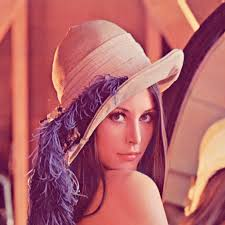

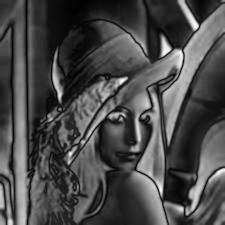

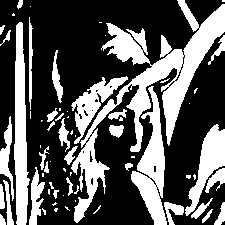

In [10]:
# compute the saliency map
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency.computeSaliency(image)

saliencyMap = (saliencyMap * 255).astype("uint8")
threshMap = cv2.threshold(saliencyMap.astype("uint8"), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# show the images
cv2_imshow(image)
cv2_imshow(saliencyMap)
cv2_imshow(threshMap)

#####Objectness Saliency Detection : BING

In [0]:
# max number of objects to detect
max_detections = 4

In [0]:
saliency = cv2.saliency.ObjectnessBING_create()
saliency.setTrainingPath(modelpath)

(success, saliencyMap) = saliency.computeSaliency(image)

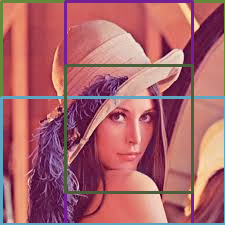

In [13]:
bboxes = []
# loop over the detections
for i in range(0, min(saliencyMap.shape[0], max_detections)):
  # extract the bounding box coordinates
  (startX, startY, endX, endY) = saliencyMap[i].flatten()
  bboxes.append([startX, startY, endX, endY])

output = image.copy()

for i in range(len(bboxes)):
  # randomly generate a color for the object and draw it on the image
  color = np.random.randint(0, 255, size=(3,))
  color = [int(c) for c in color]
  cv2.rectangle(output, (bboxes[i][0], bboxes[i][1]), (bboxes[i][2], bboxes[i][3]), color, 2)
  # show the output image
  cv2.waitKey(0)

cv2_imshow(output)

###Saliency Detection via Graph-Based Manifold Ranking

Based on : C. Yang, L. Zhang, H. Lu, X. Ruan, and M. H. Yang.
Saliency detection via graph-based manifold ranking. In
Computer Vision and Pattern Recognition (CVPR), 2013
IEEE Conference on, pages 3166–3173, June 2013.

#####Import Python implementation of the paper

In [0]:
####################################################################
## Author:
##       Xiang Ruan
##       httpr://ruanxiang.net
##       ruanxiang@gmail.com
## License:
##       GPL 2.0
##       NOTE: the algorithm itself is patented by OMRON, co, Japan
##             my previous employer, so please do not use the algorithm in
##             any commerical product
## Version:
##       1.01
##
## ----------------------------------------------------------------
## A python implementation of manifold ranking saliency
## Usage:
##      import MR
##      import matplotlib.pyplot as plt
##      mr = MR.MR_saliency()
##      sal = mr.saliency(img)
##      plt.imshow(sal)
##      plt.show()
##
## Check paper.pdf for algorithm details 
## I leave all th parameters open to maniplating, however, you don't
## have to do it, default values work pretty well, unless you really
## know what you want to do to modify the parameters


import scipy as sp
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.data import camera
from scipy.linalg import pinv

cv_ver = int(cv2.__version__.split('.')[0])
_cv2_LOAD_IMAGE_COLOR = cv2.IMREAD_COLOR if cv_ver >= 3 else cv2.CV_LOAD_IMAGE_COLOR


class MR_saliency(object):
    """Python implementation of manifold ranking saliency"""
    weight_parameters = {'alpha':0.99,
                         'delta':0.1}
    superpixel_parameters = {'segs':200,
                             'compactness':10,
                             'max_iter':10,
                             'sigma':1,
                             'spacing':None,
                             'multichannel':True,
                             'convert2lab':None,
                             'enforce_connectivity':False,
                             'min_size_factor':0.5,
                             'max_size_factor':3,
                             'slic_zero':False}
    binary_thre = None

    def __init__(self, alpha = 0.99, delta = 0.1,
                 segs = 200, compactness = 10,
                 max_iter = 10, sigma = 1,
                 spacing = None, multichannel = True,
                 convert2lab = None, enforce_connectivity = False,
                 min_size_factor = 0.5, max_size_factor = 3,
                 slic_zero = False):
        self.weight_parameters['alpha'] = alpha
        self.weight_parameters['delta'] = delta
        self.superpixel_parameters['segs'] = segs
        self.superpixel_parameters['compactness'] = compactness
        self.superpixel_parameters['max_iter'] = max_iter
        self.superpixel_parameters['sigma'] = sigma
        self.superpixel_parameters['spacing'] = spacing
        self.superpixel_parameters['multichannel'] = multichannel
        self.superpixel_parameters['convert2lab'] = convert2lab
        self.superpixel_parameters['enforce_connectivity'] = enforce_connectivity
        self.superpixel_parameters['min_size_factor'] = min_size_factor
        self.superpixel_parameters['max_size_factor'] = max_size_factor
        self.superpixel_parameters['slic_zero'] = slic_zero

    def saliency(self,img):
        # read image
        img = self.__MR_readimg(img)
        # superpixel
        labels = self.__MR_superpixel(img)
        # affinity matrix
        aff = self.__MR_affinity_matrix(img,labels)
        # first round
        first_sal = self.__MR_first_stage_saliency(aff,labels)
        # second round
        fin_sal = self.__MR_final_saliency(first_sal,labels,aff)
        return self.__MR_fill_superpixel_with_saliency(labels,fin_sal)

    
    def __MR_superpixel(self,img):
        return slic(img,self.superpixel_parameters['segs'],
                    self.superpixel_parameters['compactness'],
                    self.superpixel_parameters['max_iter'],
                    self.superpixel_parameters['sigma'],
                    self.superpixel_parameters['spacing'],
                    self.superpixel_parameters['multichannel'],
                    self.superpixel_parameters['convert2lab'],
                    self.superpixel_parameters['enforce_connectivity'],
                    self.superpixel_parameters['min_size_factor'],
                    self.superpixel_parameters['max_size_factor'],
                    self.superpixel_parameters['slic_zero'])

    def __MR_superpixel_mean_vector(self,img,labels):
        s = sp.amax(labels)+1
        vec = sp.zeros((s,3)).astype(float)
        for i in range(s):
            mask = labels == i
            super_v = img[mask].astype(float)
            mean = sp.mean(super_v,0)
            vec[i] = mean
        return vec

    def __MR_affinity_matrix(self,img,labels):        
        W,D = self.__MR_W_D_matrix(img,labels)
        aff = pinv(D-self.weight_parameters['alpha']*W)
        aff[sp.eye(sp.amax(labels)+1).astype(bool)] = 0.0 # diagonal elements to 0
        return aff

    def __MR_saliency(self,aff,indictor):
        return sp.dot(aff,indictor)

    def __MR_W_D_matrix(self,img,labels):
        s = sp.amax(labels)+1
        vect = self.__MR_superpixel_mean_vector(img,labels)
        
        adj = self.__MR_get_adj_loop(labels)
        
        W = sp.spatial.distance.squareform(sp.spatial.distance.pdist(vect))
        
        W = sp.exp(-1*W / self.weight_parameters['delta'])
        W[adj.astype(np.bool)] = 0
        

        D = sp.zeros((s,s)).astype(float)
        for i in range(s):
            D[i, i] = sp.sum(W[i])

        return W,D

    def __MR_boundary_indictor(self,labels):
        s = sp.amax(labels)+1
        up_indictor = (sp.ones((s,1))).astype(float)
        right_indictor = (sp.ones((s,1))).astype(float)
        low_indictor = (sp.ones((s,1))).astype(float)
        left_indictor = (sp.ones((s,1))).astype(float)
    
        upper_ids = sp.unique(labels[0,:]).astype(int)
        right_ids = sp.unique(labels[:,labels.shape[1]-1]).astype(int)
        low_ids = sp.unique(labels[labels.shape[0]-1,:]).astype(int)
        left_ids = sp.unique(labels[:,0]).astype(int)

        up_indictor[upper_ids] = 0.0
        right_indictor[right_ids] = 0.0
        low_indictor[low_ids] = 0.0
        left_indictor[left_ids] = 0.0

        return up_indictor,right_indictor,low_indictor,left_indictor

    def __MR_second_stage_indictor(self,saliency_img_mask,labels):
        s = sp.amax(labels)+1
        # get ids from labels image
        ids = sp.unique(labels[saliency_img_mask]).astype(int)
        # indictor
        indictor = sp.zeros((s,1)).astype(float)
        indictor[ids] = 1.0
        return indictor

    def __MR_get_adj_loop(self, labels):
        s = sp.amax(labels) + 1
        adj = np.ones((s, s), np.bool)

        for i in range(labels.shape[0] - 1):
            for j in range(labels.shape[1] - 1):
                if labels[i, j] != labels[i+1, j]:
                    adj[labels[i, j],       labels[i+1, j]]              = False
                    adj[labels[i+1, j],   labels[i, j]]                  = False
                if labels[i, j] != labels[i, j + 1]:
                    adj[labels[i, j],       labels[i, j+1]]              = False
                    adj[labels[i, j+1],   labels[i, j]]                  = False
                if labels[i, j] != labels[i + 1, j + 1]:
                    adj[labels[i, j]        ,  labels[i+1, j+1]]       = False
                    adj[labels[i+1, j+1],  labels[i, j]]               = False
                if labels[i + 1, j] != labels[i, j + 1]:
                    adj[labels[i+1, j],   labels[i, j+1]]              = False
                    adj[labels[i, j+1],   labels[i+1, j]]              = False
        
        upper_ids = sp.unique(labels[0,:]).astype(int)
        right_ids = sp.unique(labels[:,labels.shape[1]-1]).astype(int)
        low_ids = sp.unique(labels[labels.shape[0]-1,:]).astype(int)
        left_ids = sp.unique(labels[:,0]).astype(int)
        
        bd = np.append(upper_ids, right_ids)
        bd = np.append(bd, low_ids)
        bd = sp.unique(np.append(bd, left_ids))
        
        for i in range(len(bd)):
            for j in range(i + 1, len(bd)):
                adj[bd[i], bd[j]] = False
                adj[bd[j], bd[i]] = False

        return adj
        
    def __MR_fill_superpixel_with_saliency(self,labels,saliency_score):
        sa_img = labels.copy().astype(float)
        for i in range(sp.amax(labels)+1):
            mask = labels == i
            sa_img[mask] = saliency_score[i]
        return cv2.normalize(sa_img,None,0,255,cv2.NORM_MINMAX)

    def __MR_first_stage_saliency(self,aff,labels):
        up,right,low,left = self.__MR_boundary_indictor(labels)
        up_sal = 1- self.__MR_saliency(aff,up)
        up_img = self.__MR_fill_superpixel_with_saliency(labels,up_sal)
    
        right_sal = 1-self.__MR_saliency(aff,right)
        right_img = self.__MR_fill_superpixel_with_saliency(labels,right_sal)

        low_sal = 1-self.__MR_saliency(aff,low)
        low_img = self.__MR_fill_superpixel_with_saliency(labels,low_sal)
    
        left_sal = 1-self.__MR_saliency(aff,left)
        left_img = self.__MR_fill_superpixel_with_saliency(labels,left_sal)

        return 1- up_img*right_img*low_img*left_img


    def __MR_final_saliency(self,integrated_sal, labels, aff):
        # get binary image
        if self.binary_thre == None:
            thre = sp.median(integrated_sal.astype(float))

        mask = integrated_sal > thre
        # get indicator
        ind = self.__MR_second_stage_indictor(mask,labels)
    
        return self.__MR_saliency(aff,ind)

    # read image
    def __MR_readimg(self,img):
        if isinstance(img,str): # a image path
            img = cv2.imread(img, _cv2_LOAD_IMAGE_COLOR)
        img = cv2.cvtColor(img,cv2.COLOR_RGB2LAB).astype(float)/255
        # Keeping the image in full size
        #h = 100
        #w = int(float(h)/float(img.shape[0])*float(img.shape[1]))
        #return cv2.resize(img,(w,h))
        return img


class MR_debuger(MR_saliency):
    def MR_showsuperpixel(self,img=None):
        if img == None:
            img = cv2.cvtColor(camera(),cv2.COLOR_RGB2BGR)
        img = self._MR_saliency__MR_readimg(img)
        labels = self._MR_saliency__MR_superpixel(img)

        plt.axis('off')
        plt.imshow(mark_boundaries(img,labels))
        plt.show()

    def MR_boudnary_extraction(self,img=None):
        if img == None:
            img = cv2.cvtColor(camera(),cv2.COLOR_RGB2BGR)
        lab_img = self._MR_saliency__MR_readimg(img)
        mark_color = (1,0,0)
        labels = self._MR_saliency__MR_superpixel(lab_img)

        up_img = lab_img.copy()
        up_ids = sp.unique(labels[0,:]).astype(int)
        up_mask = sp.zeros(labels.shape).astype(bool)
        for i in up_ids:
            up_mask = sp.logical_or(up_mask,labels==i)
        up_img[up_mask] = mark_color
        up_img = mark_boundaries(up_img,labels)

        right_img = lab_img.copy()
        right_ids = sp.unique(labels[:,labels.shape[1]-1]).astype(int)
        right_mask = sp.zeros(labels.shape).astype(bool)
        for i in right_ids:
            right_mask = sp.logical_or(right_mask,labels==i)
        right_img[right_mask] = mark_color
        right_img = mark_boundaries(right_img,labels)


        low_img = lab_img.copy()
        low_ids = sp.unique(labels[labels.shape[0]-1,:]).astype(int)
        low_mask = sp.zeros(labels.shape).astype(bool)
        for i in low_ids:
            low_mask = sp.logical_or(low_mask,labels==i)
        low_img[low_mask] = mark_color
        low_img = mark_boundaries(low_img,labels)
        
        left_img = lab_img.copy()
        left_ids = sp.unique(labels[:,0]).astype(int)
        left_mask = sp.zeros(labels.shape).astype(bool)
        for i in left_ids:
            left_mask = sp.logical_or(left_mask,labels==i)
        left_img[left_mask] = mark_color
        left_img = mark_boundaries(left_img,labels)

        plt.subplot(2,2,1)
        plt.axis('off')
        plt.title('up')
        plt.imshow(up_img)

        plt.subplot(2,2,2)
        plt.axis('off')
        plt.title('bottom')
        plt.imshow(low_img)


        plt.subplot(2,2,3)
        plt.axis('off')
        plt.title('left')
        plt.imshow(left_img)

        plt.subplot(2,2,4)
        plt.axis('off')
        plt.title('right')
        plt.imshow(right_img)

        plt.show()


    def MR_boundary_saliency(self,img=None):
        if img == None:
            img = cv2.cvtColor(camera(),cv2.COLOR_RGB2BGR)
        lab_img = self._MR_saliency__MR_readimg(img)
    
        labels = self._MR_saliency__MR_superpixel(lab_img)
        
        up,right,low,left = self._MR_saliency__MR_boundary_indictor(labels)
        aff = self._MR_saliency__MR_affinity_matrix(lab_img,labels)

        up_sal = 1- self._MR_saliency__MR_saliency(aff,up)
        up_img = self._MR_saliency__MR_fill_superpixel_with_saliency(labels,up_sal)
        up_img = up_img.astype(np.uint8)
    
        right_sal = 1-self._MR_saliency__MR_saliency(aff,right)
        right_img =  self._MR_saliency__MR_fill_superpixel_with_saliency(labels,right_sal)
        right_img = right_img.astype(np.uint8)

        low_sal = 1-self._MR_saliency__MR_saliency(aff,low)
        low_img = self._MR_saliency__MR_fill_superpixel_with_saliency(labels,low_sal)
        low_img = low_img.astype(np.uint8)
    
        left_sal = 1-self._MR_saliency__MR_saliency(aff,left)
        left_img = self._MR_saliency__MR_fill_superpixel_with_saliency(labels,left_sal)
        left_img = left_img.astype(np.uint8)
        

        plt.subplot(3,2,1)
        plt.title('orginal')
        plt.axis('off')
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        
        plt.subplot(3,2,2)
        plt.title('up')
        plt.axis('off')
        plt.imshow(up_img,'gray')
        
        plt.subplot(3,2,3)
        plt.title('right')
        plt.axis('off')
        plt.imshow(right_img,'gray')
        
        plt.subplot(3,2,4)
        plt.title('low')
        plt.axis('off')
        plt.imshow(low_img,'gray')
        
        plt.subplot(3,2,5)
        plt.title('left')
        plt.axis('off')
        plt.imshow(left_img,'gray')
        
        plt.subplot(3,2,6)
        plt.title('integrated')
        plt.axis('off')
        saliency_map = MR_debuger().saliency(img).astype(np.uint8)
        plt.imshow( saliency_map,'gray')
        plt.show()

#####Usage

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: scipy.amax is deprecated and will be removed in SciPy 2.0.0, use numpy.amax instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: scipy.amax is deprecated and will be removed in SciPy 2.0.0, use numpy.amax instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: DeprecationWarning: scipy.amax is deprecated and will be removed in SciPy 2.0.0, use numpy.amax instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: DeprecationWarning: scipy.unique is deprecated and will be removed in SciPy 2.0.0, use

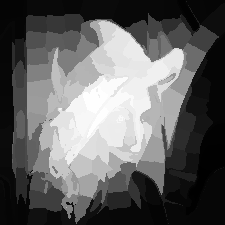

In [15]:
mr = MR_saliency()
sal = mr.saliency(image)
cv2_imshow(sal)

In [16]:
sal.mean()

98.9087909265704

##Patern Diversity

###Edge

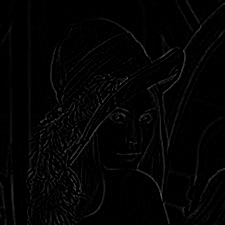

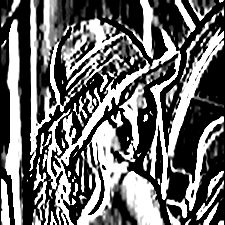

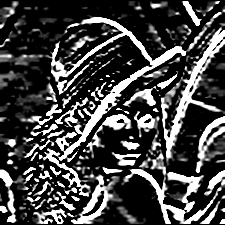

In [17]:
# opencv : Laplacian + Sobel (x,y)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_clean = cv2.GaussianBlur(gray,(3,3),0)

laplacian = cv2.Laplacian(gray_clean,cv2.CV_64F)
sobel_x = cv2.Sobel(gray_clean,cv2.CV_64F,1,0,ksize=5)
sobel_y = cv2.Sobel(gray_clean,cv2.CV_64F,0,1,ksize=5) 

cv2_imshow(laplacian)
cv2_imshow(sobel_x)
cv2_imshow(sobel_y)

# We are going to keep the sobels
sigma_ex = np.var(sobel_x)
sigma_ey = np.var(sobel_y)

###Chrominance

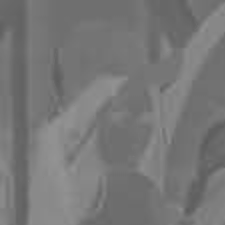

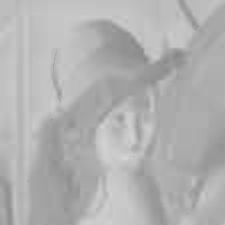

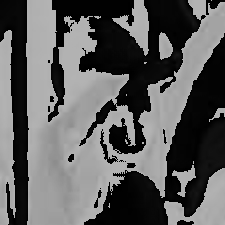

In [18]:
# In YUV format, Y is Luminance, and (U, V) are chromaninance mesures (Blue & Red projections)
image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

U = image_yuv[:, :, 1] 
V = image_yuv[:, :, 2]

cv2_imshow(U)
cv2_imshow(V)

sigma_cu = np.var(U)
sigma_cv = np.var(V)

# HSL format
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

H = image_hsv[:, :, 0]

cv2_imshow(H)

sigma_h = np.var(H)

###Wasserstein's Distance

Based on : F. Pitie and A. Kokaram. The linear monge-kantorovitch linear colour mapping for example-based colour transfer. In Visual Media Production, 2007. IETCVMP. 4th European Conference on, pages 1–9, Nov 2007.

In [0]:
def wassertsteinDistance(sigma_i, sigma_j):
  sigma_i_sqrt = fractional_matrix_power(sigma_i, .5)
  sigma_i_sqrt_inv = inv(sigma_i_sqrt)
  sigma_temp = fractional_matrix_power(np.nan_to_num(np.dot(np.dot(sigma_i_sqrt, sigma_j), sigma_i_sqrt)), 0.5)
  return np.dot(np.dot(sigma_i_sqrt_inv, sigma_temp), sigma_i_sqrt_inv)

In [0]:
sigma = np.diag([sigma_h, sigma_ex, sigma_ey])

In [21]:
#test
emd = wassertsteinDistance(sigma, sigma)
emd

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

##Overlapping Constraint


Simple Euclidian distance

In [0]:
def euclidean_dist(u, v):
  return np.linalg.norm(u - v)

#Implementation

##Utils

In [0]:
def wassertsteinDistance(sigma_i, sigma_j):
  # Following F. Pitie and A. Kokaram
  for i in range(sigma_i.shape[0]):
    if sigma_i[i][i] == 0: 
      sigma_i[i][i] += 0.1
    if sigma_j[i][i] == 0: 
      sigma_j[i][i] += 0.1

  sigma_i_sqrt = fractional_matrix_power(sigma_i, .5)
  sigma_i_sqrt_inv = np.linalg.inv(sigma_i_sqrt)
  sigma_intermediate = np.dot(sigma_i_sqrt, sigma_j)
  sigma_temp = fractional_matrix_power(np.nan_to_num(np.dot(sigma_intermediate, sigma_i_sqrt)), .5)

  #pdb.set_trace()

  return np.dot(np.dot(sigma_i_sqrt_inv, sigma_temp), sigma_i_sqrt_inv)

def D_p(E_x_i, E_x_j, E_y_i, E_y_j, H_i, H_j):
  # Pattern Diversity
  ## Edge 
  sigma_e_x_i = np.var(E_x_i)
  sigma_e_x_j = np.var(E_x_i)

  sigma_e_y_i = np.var(E_y_i)
  sigma_e_y_j = np.var(E_y_i)

  ## Chrominance
  sigma_h_i = np.var(H_i)
  sigma_h_j = np.var(H_j)

  # Earth's Mover Distance 
  sigma_i = np.diag([sigma_e_x_i, sigma_e_y_i, sigma_h_i])
  sigma_j = np.diag([sigma_e_x_j, sigma_e_y_j, sigma_h_j])

  emd = wassertsteinDistance(sigma_i, sigma_j)
  
  return np.trace(emd) / emd.shape[0]

In [0]:
def preComputeF(image):
  # Compute maps
  ## S saliency map
  mr = MR_saliency()

  S = np.asarray(mr.saliency(image))

  ## E_x, E_y edge maps (on x & y)
  gray = cvtColor(image, COLOR_BGR2GRAY)
  gray_clean = GaussianBlur(gray,(3,3),0)
  E_x = np.asarray(Sobel(gray_clean, CV_64F,1,0,ksize=5))
  E_y = np.asarray(Sobel(gray_clean, CV_64F,0,1,ksize=5))

  ## H chrominancy map ; we chose to use hue to score "colorfullness"
  #Hue formula from BGR following Frank Preucil, 1953
  H = np.arctan2(np.sqrt(3) * (image[:, :, 1] - image[:, :, 0]), 2 * image[:, :, 2] - image[:, :, 1] - image[:, :, 0])

  #pdb.set_trace()

  return S, E_x, E_y, H


def computeF(S, E_x, E_y, H, centers, patch_size=[224, 224]):
  #<0 : to minimize
  centers = centers.reshape(-1, 2).astype(int)

  F = 0

  ## To sum saliency, important : highly dependent on the combination method, here fitted for itertools.combinations
  first_loop = True
  number_loop = 0

  # Compute patches
  for center in itertools.combinations(centers, 2):
    #Careful : cv2 is switching axis so we have to switch centers coordinates accordingly

    #print(number_loop)
    E_x_i = E_x[(center[0][1] - patch_size[0]):(center[0][1] + patch_size[0] + 1), (center[0][0] - patch_size[1]):(center[0][0] + patch_size[1] + 1)]

    #2 * radius + 1 (center pixel)
    if (E_x_i.size == 0) or (E_x_i.shape[0] != patch_size[0] * 2 + 1) or (E_x_i.shape[1] != patch_size[1] * 2 + 1):
      #print("The patch i is stepping outside of the image.")
      return 1

    E_x_j = E_x[(center[1][1] - patch_size[0]):(center[1][1] + patch_size[0] + 1), (center[1][0] - patch_size[1]):(center[1][0] + patch_size[1] + 1)]

    if (E_x_j.size == 0) or (E_x_j.shape[0] != patch_size[0] * 2 + 1) or (E_x_j.shape[1] != patch_size[1] * 2 + 1):
      # Given that all of the maps are of the same dimension, only E_x on i and j is enough
      #print("The patch j is stepping outside of the image.")
      return 1

    E_y_i = E_y[(center[0][1] - patch_size[0]):(center[0][1] + patch_size[0] + 1), (center[0][0] - patch_size[1]):(center[0][0] + patch_size[1] + 1)]
    E_y_j = E_x[(center[1][1] - patch_size[0]):(center[1][1] + patch_size[0] + 1), (center[1][0] - patch_size[1]):(center[1][0] + patch_size[1] + 1)]

    H_i = H[(center[0][1] - patch_size[0]):(center[0][1] + patch_size[0] + 1), (center[0][0] - patch_size[1]):(center[0][0] + patch_size[1] + 1)]
    H_j = H[(center[1][1] - patch_size[0]):(center[1][1] + patch_size[0] + 1), (center[1][0] - patch_size[1]):(center[1][0] + patch_size[1] + 1)]

    # Summing saliency
    if first_loop:
      F += S[(center[0][0] - patch_size[0]):(center[0][0] + patch_size[0] + 1), (center[0][1] - patch_size[1]):(center[0][1] + patch_size[1] + 1)].mean()
      first_loop = False
    if number_loop < centers.shape[0] - 1:
      F += S[(center[1][0] - patch_size[0]):(center[1][0] + patch_size[0] + 1), (center[1][1] - patch_size[1]):(center[1][1] + patch_size[1] + 1)].mean()
      number_loop += 1

    # Pattern diversity (emd)
    F = F + D_p(E_x_i, E_x_j, E_y_i, E_y_j, H_i, H_j)
    
    # Euclidean distance between centers
    F = F + np.linalg.norm(center[0] - center[1]) / 2 

  return - F

In [0]:
def initialize_five_centers_x(image, patch_size):
  shape = image.shape[1], image.shape[0]
  safety = 1                                                                            #pixel margin
  x0 = [patch_size[0] + safety, patch_size[1] + safety,                                 #top left
        shape[0] - patch_size[0] - safety, patch_size[1] + safety,                      #top right
        patch_size[0] + safety, shape[1] - patch_size[1] - safety,                      #bottom left
        shape[0] - patch_size[0] - safety, shape[1] - patch_size[1] - safety,           #bottom right
        shape[0] // 2, shape[1] // 2]                                                   #middle                   
                
  return np.array(x0)

In [0]:
def initialize_five_centers_line(image, patch_size):
  shape = image.shape[1], image.shape[0]
  safety = 1 

  if shape[1] > shape[0]:
    y0 = shape[1] // 2
    x_step = (shape[0] - 2*patch_size[0]) // 5
                                                                              
    x = [patch_size[0] + safety, y0,
          patch_size[0] + x_step, y0,
          patch_size[0] + 2*x_step, y0,
          patch_size[0] + 3*x_step, y0,
          patch_size[0] + 4*x_step - safety, y0]    

  else:
    x0 = shape[0] // 2
    y_step = (shape[1] - 2*patch_size[1]) // 5
                                                                              
    x = [x0, patch_size[1] + safety,
         x0, patch_size[1] + y_step, 
         x0, patch_size[1] + 2*y_step, 
         x0, patch_size[1] + 3*y_step, 
         x0, patch_size[1] + 4*y_step - safety] 
                
  return np.array(x)

##Test 1

In [0]:
from scipy.optimize import minimize

In [0]:
#scipy raises too many warnings (transitioning math functions from numpy to scipy)
import warnings
warnings.filterwarnings('ignore')

In [50]:
ls '{datapath}'

15.jpg                   challenges.txt  man.jpg
aesthetics_image_lists/  forest.png      objectness_trained_model/
AVA.csv                  girl.jpg        README.txt
AVA.txt                  good.jpg        style_image_lists/
bad_bboxes.pickle        highres2.jpg    tags.csv
bad.jpg                  highres.jpg     tags.txt
big.jpg                  lena.jpeg
challenges.csv           loups.jpg


In [0]:
imagename = os.path.join(datapath, 'good.jpg')
image = cv2.imread(imagename)

In [52]:
patch_size = [112, 112]
x0 = initialize_five_centers_line(image, patch_size)

S, E_x, E_y, H = preComputeF(image)

start = time.time()

res = minimize(lambda x : computeF(S, E_x, E_y, H, x, patch_size), \
                     x0, \
                     method='Nelder-Mead', \
                     options={'xatol': 100, 'disp': True})
print('RUNTIME : ' + str(time.time() - start))

Optimization terminated successfully.
         Current function value: -6799.158652
         Iterations: 317
         Function evaluations: 552
RUNTIME : 11.408316373825073


In [53]:
centers = np.asarray(res.x.reshape(-1, 2).astype(int))
patch_size = [112, 112]
image2 = cv2.imread(imagename)

for center in centers:
  print(center)
  cv2.circle(image2, (center[0], center[1]), 2, (0, 0, 255), 2) 
  cv2.rectangle(image2, (center[0] - patch_size[0], center[1] - patch_size[0]), (center[0] + patch_size[1], center[1] + patch_size[1]), (255, 0, 0), 1)

cv2_imshow(image2)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
centers = res.x.reshape(-1, 2).astype(int)
bboxes = np.concatenate((centers[:, [0]] - patch_size[0], centers[:, [1]] - patch_size[1], centers[:, [0]] + patch_size[0], centers[:, [1]] + patch_size[1]), axis=1)
temp = {'Filename': [imagename], 'BBoxes': [bboxes]}
df = pd.DataFrame(temp)

pickle_out = open(os.path.join(datapath, 'good_bboxes.pickle'), 'wb')
pickle.dump(df, pickle_out)
pickle_out.close()

##Test Multiple

Optimization terminated successfully.
         Current function value: -1612.874332
         Iterations: 337
         Function evaluations: 585
RUNTIME : 14.59594178199768
[110 299]
[119 361]
[218 113]
[316 529]
[316 138]


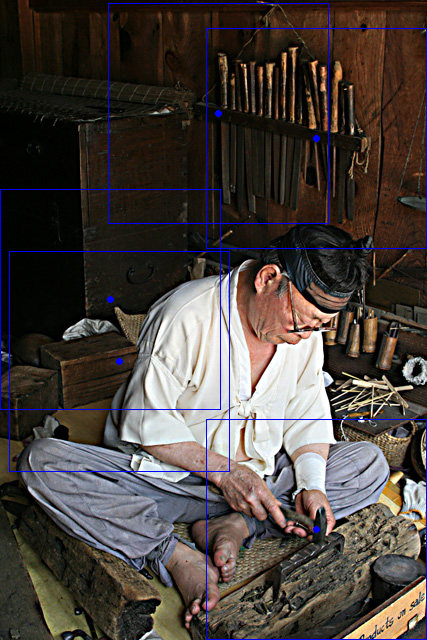

Optimization terminated successfully.
         Current function value: -1560.789147
         Iterations: 216
         Function evaluations: 379
RUNTIME : 8.823370933532715
[307 110]
[456 178]
[110 239]
[242 316]
[160 316]


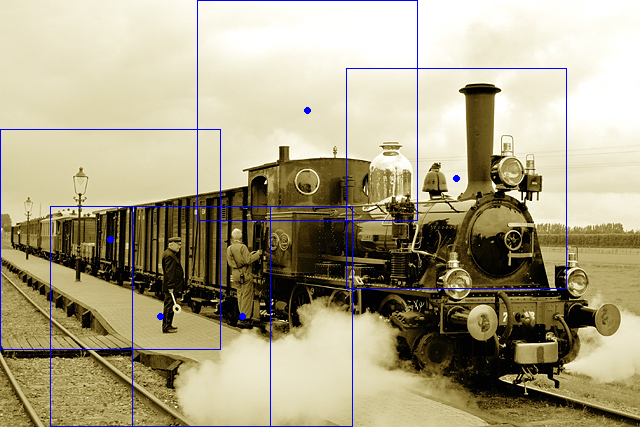

Optimization terminated successfully.
         Current function value: -1548.253288
         Iterations: 270
         Function evaluations: 482
RUNTIME : 10.485043287277222
[115 400]
[152 518]
[198 118]
[198 375]
[315 110]


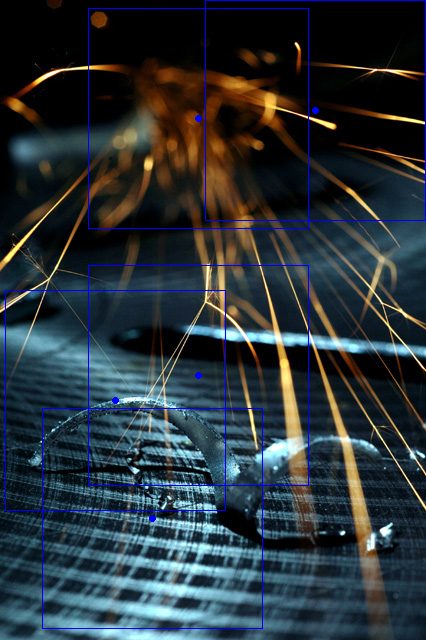

KeyboardInterrupt: ignored

In [33]:
for i in range(1, 7):
  start = time.time()
  #load image
  imagename = os.path.join(testpath, str(i) + '.png')
  image = cv2.imread(imagename)

  #setup for image
  patch_size = [110, 110]
  x0 = initialize_five_centers_line(image, patch_size)
  #x0 = np.array(5 * list(np.array(image.shape[::-1][1::]) // 2))
  S, E_x, E_y, H = preComputeF(image)

  res = minimize(lambda x : computeF(S, E_x, E_y, H, x, patch_size), \
                      x0, \
                      method='Nelder-Mead', \
                      options={'xatol': 10, 'disp': True})
  print('RUNTIME : ' + str(time.time() - start))

  centers = np.asarray(res.x.reshape(-1, 2).astype(int))
  patch_size = [110, 110]

  for center in centers:
    print(center)
    cv2.circle(image, (center[0], center[1]), 2, (255, 0, 0), 2) 
    cv2.rectangle(image, (center[0] - patch_size[0], center[1] - patch_size[0]), (center[0] + patch_size[1], center[1] + patch_size[1]), (255, 0, 0), 1)

  # centers = np.asarray(x0.reshape(-1, 2).astype(int))
  # for center in centers:
  #   print(center)
  #   cv2.circle(image, (center[0], center[1]), 2, (0, 0, 255), 2) 
  #   cv2.rectangle(image, (center[0] - patch_size[0], center[1] - patch_size[0]), (center[0] + patch_size[1], center[1] + patch_size[1]), (0, 0, 255), 1)


  cv2_imshow(image)